# Q1.1 - Use of two rigid body transformation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import utils as ut

I = np.eye(3)
Z = np.zeros((3,3))

#Position vectors of points
l_wx = np.array([[1], [-0.1], [0.4]]) #in frame B1
l_yz = np.array([[1], [0], [0.2]]) #in frame B2

#Spatial velocities of w with respect to I in frame B1
V_Iw = np.array([1.2,0.7,0,0.3,0,2.1]).reshape((6,1))

#Quarternions representing orientations
q_IB1 = np.array([1/(np.sqrt(3)*2),1/(np.sqrt(3)*2), 1/(np.sqrt(3)*2), np.sqrt(3)/2]).reshape(4,1) #B1 to I
q_B1B2 = np.array([1/(np.sqrt(3)*2),-1/(np.sqrt(3)*2), 1/(np.sqrt(3)*2), np.sqrt(3)/2]).reshape(4,1) #B2 to B1 (same rotation as B1 to I)

#Hinge map in non-rigid case
H = np.block([np.eye(3), np.zeros((3,3))])

#Rotation matrices
R_IB1 = ut.rotfromquat(q_IB1)
R_B1B2 = ut.rotfromquat(q_B1B2)

#1.1.1 Single transformation
l_wz = R_IB1 @ (l_wx + R_B1B2 @ l_yz) #Vector from w to z in inertial frame
phi_wz = ut.rigidbodytransform(l_wz) #in intertial frame

V_Iz = phi_wz.T @ np.block([[R_IB1, Z],[Z, R_IB1]]) @ V_Iw #Spatial velocity of point z with respect to I in inertial frame

print(V_Iz)

#1.1.2 Chaining
theta_dot = np.array([3.2, 0, 1.2]).reshape((3,1)) #Generalized hinge velocities

phi_wx = ut.rigidbodytransform(l_wx) #in frame B1

#calculating spatial velocity at y - so first tranform from w to x, then adding the hinge contribution
phi_wx = ut.rigidbodytransform(l_wx) #in frame B1
V_Iy = phi_wx.T @ V_Iw + H.T @ theta_dot

#Rigid body transform from y to z, in frame B2
phi_yz = ut.rigidbodytransform(l_yz)

#Velocity of z with respect to I in frame B2
V_Iz = phi_yz.T @ np.block([[R_B1B2.T, Z],[Z, R_B1B2.T]]) @ V_Iy

# In intertial

V_Iz_in_I = np.block([[R_IB1, Z],[Z, R_IB1]])@np.block([[R_B1B2, Z],[Z, R_B1B2]]) @ V_Iz

print(V_Iz_in_I)



[[ 0.56666667]
 [ 1.26666667]
 [ 0.06666667]
 [ 1.97333333]
 [-0.56666667]
 [-0.60666667]]
[[ 3.5       ]
 [ 3.        ]
 [-0.2       ]
 [ 2.85333333]
 [-2.16666667]
 [-1.32666667]]


# Q1.2

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import utils as ut
from scipy.integrate import solve_ivp
I = np.eye(3)
Z = np.zeros((3,3))

#Everything in the code is written in the centroidal frame C unless explicitly stated otherwise

#Initial conditions
beta_c0 = np.zeros((6,1)) #Initial generalized coordinates of the system
q0 = np.array([0,0,0,1]).reshape((4,1)) #Innitial orientation - axis algined
l0 = np.array([0.5,1,0]).reshape((3,1)) #This ensures origins align og C and I. This is the initial state of the vector l(I,z), and i just set it equal to l(C,z) at t=0
state0 = np.vstack((beta_c0,q0,l0))


#ODE function
def odefun(t,state):

    #unpacking state
    Nu = state[:6] #Generalized velocities
    q = state[6:10] #Orientation quaternion
    l = state[10:13] #Position vector of poinrt p

    #normalizing quaternion
    q = q / np.linalg.norm(q)

    #parameters
    J = np.diag([500, 50, 500]) 
    m = 100 #mass
    F_z = np.array([0, 0, 0, 0, 0, 50]) #Spatial forces applied at point z 
    l_Cz = np.array([0.5, 1, 0])
    M_c = np.block([[J, Z],[Z, m*I]]) #Spatial mass matrix at centroid C

    #rigid body transform phi(z,C)
    phi_zC = ut.rigidbodytransform(-l_Cz) #note the negative, as l_zC = - l_Cz

    #Spatial inertia at point z
    M_z = phi_zC @ M_c @ phi_zC.T

    #rotation from C to I
    R = ut.rotfromquat(q)

    #equation of motion at point z expressed in body frame
    b_z = ut.spatialskewbar(Nu) @ M_z @ Nu

    Nu_dot = np.linalg.solve(M_z, F_z - b_z)

    #quarternion derrivative
    omega = Nu[:3].reshape((3,1)) #angular velocity
    q_dot = 1/2*np.block([[-ut.skewfromvec(omega), omega],[-omega.T, np.zeros((1,1))]]) @ q

    #position derrivative
    v = Nu[3:] #linear velocity
    l_dot = R @ v #rotated to inertial frame

    state_dot = np.concatenate([
        Nu_dot.flatten(), 
        q_dot.flatten(), 
        l_dot.flatten()
    ])
    return state_dot

#Solving
tspan = (0.0, 5.0)

sol = solve_ivp(odefun, tspan, state0.flatten(), method='RK45',max_step=0.01)


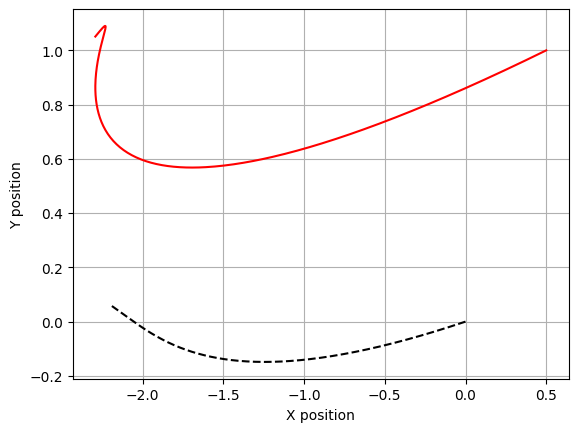

In [22]:
#plotting results
time = sol.t
l_sol = sol.y[10:13,:]
n_steps = sol.y.shape[1]
l_Cz = np.array([0.5, 1, 0])


#storage array for position of COM in inertial frame
I_l_Ic = np.zeros((3,n_steps))
for i in range(n_steps):
    q = sol.y[6:10,i].reshape((4,1))
    R = ut.rotfromquat(q)

    I_l_Ic[:,i] = l_sol[:,i] - R@l_Cz


plt.plot(I_l_Ic[0, :], I_l_Ic[1, :], 'k--')
plt.plot(l_sol[0, :], l_sol[1, :], 'r-')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.grid()
plt.show()


In [18]:
F_z = np.array([0, 0, 0, 0, 0, 50]).reshape((6,1))